### Introduction 
This notebook is created based on this research paper [**PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts**](https://arxiv.org/pdf/1710.06071.pdf)<br>

The summary of this reseach paper is that, it converts medical research paper **Abstract's** each sentence to a category (background, objective, methods, results, conclusions).

### Getting the data
Good thing is that data is publicly available.

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls /kaggle/working/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


`dev.txt` is validation set <br>
`test.txt` is test set and<br>
`train.txt` is train set

In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocessing data

In [8]:
def read_lines(filename):
    with open(filename) as file:
        return file.readlines()

In [9]:
filenames[0]

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'

In [10]:
train_file = read_lines(filename=filenames[1])
train_file[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [11]:
def preprocess_text(filename):
    
    input_lines = read_lines(filename)

    abstract_lines = ""
    abstracts = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_lines = ""

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_split = abstract_line.split("\t")
                line_data["target"] = line_split[0]
                line_data["text"] = line_split[1].lower()
                line_data["line_number"] = abstract_line_number + 1
                line_data["total_lines"] = len(abstract_line_split)
                abstracts.append(line_data)
        else:
            abstract_lines += line
    
    return abstracts

In [12]:
abstracts = preprocess_text(filename=filenames[0])
abstracts[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 4,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Visualizing Data

In [14]:
train_samples = preprocess_text(filename=data_dir + "train.txt")
dev_samples = preprocess_text(filename=filenames[1])
test_samples = preprocess_text(filename=filenames[2])

In [15]:
import pandas as pd

In [16]:
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

In [17]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,8,12
180036,RESULTS,"for pav , a significantly greater percentage o...",9,12
180037,RESULTS,both strategies had acceptable side effect pro...,10,12
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",11,12


In [18]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

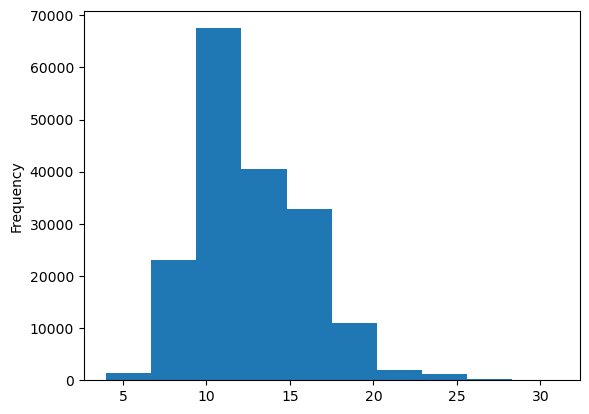

In [19]:
train_df["total_lines"].plot.hist();

In [20]:
len(train_df["text"]), len(dev_df["text"]), len(test_df["text"])

(180040, 30135, 30212)

### Splitting Data

In [21]:
train_sentences = train_df["text"]
val_sentences = dev_df["text"]
test_sentences = test_df["text"]

In [22]:
train_target = train_df["target"]
val_target = dev_df["target"]
test_target = test_df["target"]

### `OneHotEncoder`

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_target_hot_encoder = one_hot_encoder.fit_transform(train_target.to_numpy().reshape(-1,1)) 
val_target_hot_encoder = one_hot_encoder.fit_transform(val_target.to_numpy().reshape(-1,1)) 
test_target_hot_encoder = one_hot_encoder.fit_transform(test_target.to_numpy().reshape(-1,1)) 

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
train_target_hot_encoder

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### `LabelEncoder`

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
label_encoder = LabelEncoder()
train_target_label_encoder = label_encoder.fit_transform(train_target.to_numpy().reshape(-1,1))
val_target_label_encoder = label_encoder.fit_transform(val_target.to_numpy().reshape(-1,1))
test_target_label_encoder = label_encoder.fit_transform(test_target.to_numpy().reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
len(label_encoder.classes_), label_encoder.classes_

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### `model_0`: Baseline

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [30]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("multinomialNB", MultinomialNB())
])

In [31]:
model_0.fit(train_sentences, train_target_label_encoder)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('multinomialNB', MultinomialNB())])

### Evaluation function

In [32]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [33]:
def calculate_results(y_true, y_pred):
    """
    returns a dictionary of accuracy_score, precission, recall and f1_score
    """
    precission, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    acc_score = accuracy_score(y_true, y_pred) * 100
    
    results = {
        "accuracy_score": acc_score,
        "precission": precission,
        "recall": recall,
        "f1_score": f1_score
    }
    return results

In [34]:
baseline_results = calculate_results(val_target_label_encoder, model_0.predict(val_sentences))
baseline_results

{'accuracy_score': 71.6674962667994,
 'precission': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

### Text vectorization (tokenization)

In [35]:
from tensorflow.keras.layers import TextVectorization

In [36]:
import numpy as np

In [37]:
sentences_word_size = [len(sentence.split()) for sentence in train_sentences]
sentence_length = np.percentile(sentences_word_size, 95) # gives the size of sentence length for 95% sentence
sentence_length

55.0

In [38]:
max_tokens = 68000 # in the paper, for 20k dataset maximum vocabulary is 68k

In [39]:
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=int(sentence_length))

In [40]:
text_vectorization.adapt(train_sentences)

In [41]:
import random

In [42]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(f"After tokenization {text_vectorization(random_sentence)}")

the inadequacy b and c of marginal seal were more prevalent for restorations without the additional marginal seal ( group @ ) : @ of @ total ( @ % ) at @ months with inadequacy b ; @ of @ total ( @ % ) with inadequacy b and @ total ( @ % ) with inadequacy c at @ months ; @ of @ total ( @ % ) with inadequacy b and @ total ( @ % ) with inadequacy c at @ months ; @ of @ total ( @ % ) with inadequacy b and @ of @ total ( @ % ) with inadequacy c at @ months ; @ of @ total ( @ % ) with inadequacy b and @ of @ total ( @ % ) with inadequacy c at @ months .
After tokenization [   2 9400  186    3  243    4 2770 9311    9   69 1998   11 3931  159
    2  365 2770 9311   13    4   76   15   41    7 9400  186    4   76
    7 9400  186    3   76    7 9400  243   15   41    4   76    7 9400
  186    3   76    7 9400  243   15   41    4   76    7 9400  186]


In [43]:
print(f"5 most common words: {text_vectorization.get_vocabulary()[:5]}")
print(f"5 least common words: {text_vectorization.get_vocabulary()[-5:]}")

5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Embedding

In [44]:
from tensorflow.keras.layers import Embedding

In [45]:
embedding = Embedding(input_dim=max_tokens, # 68000 set earlier from paper
                     output_dim=128, # multiple of 8 can be 64, 128, 256, 512
                     mask_zero=True) # increase the computaional power for 0 

In [46]:
random_sentence = random.choice(train_sentences)
print(f"Sentence before embedding: {random_sentence}")
embedding(text_vectorization([random_sentence]))

Sentence before embedding: team grant #cif @ .


<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.02072788, -0.02587285,  0.04646574, ...,  0.04049624,
         -0.00478449, -0.01991179],
        [-0.04089959, -0.01557948,  0.04220425, ...,  0.04024689,
         -0.03556727,  0.04175818],
        [ 0.04053501,  0.03639022, -0.02215151, ..., -0.03205635,
          0.03477449,  0.01907653],
        ...,
        [ 0.0056703 ,  0.01997092, -0.04933479, ..., -0.02289456,
          0.04682095, -0.04377251],
        [ 0.0056703 ,  0.01997092, -0.04933479, ..., -0.02289456,
          0.04682095, -0.04377251],
        [ 0.0056703 ,  0.01997092, -0.04933479, ..., -0.02289456,
          0.04682095, -0.04377251]]], dtype=float32)>

**Note:** If we see the shape of the embedded sentence, we will notice it is (1, 55, 128)
which means from every sentence we will take 55 words and each word will be represented with 128 shape matrix.

### Creating Datasets

In [49]:
import tensorflow as tf

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_target_hot_encoder))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_target_hot_encoder))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_target_hot_encoder))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [53]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### `model_1`: Conv1D

In [54]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorization(inputs)
token_embeddings = embedding(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_conv1D")

In [55]:
model_1.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                

In [56]:
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [57]:
history_conv1D = model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 62ms/step - loss: 0.8366 - accuracy: 0.6797 - val_loss: 0.6034 - val_accuracy: 0.7729
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.5780 - accuracy: 0.7888 - val_loss: 0.5469 - val_accuracy: 0.7975
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.5407 - accuracy: 0.8007 - val_loss: 0.5244 - val_accuracy: 0.7982


In [59]:
model_1.evaluate(val_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.5375 - accuracy: 0.8001


[0.537507176399231, 0.8000995516777039]

In [60]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

942/942 [==============================] - 2s 2ms/step


array([[3.68172765e-01, 6.14928640e-02, 1.51051104e-01, 3.97385567e-01,
        2.18977351e-02],
       [1.51750045e-02, 1.47019606e-02, 8.53987753e-01, 8.69448949e-03,
        1.07440807e-01],
       [1.56718379e-04, 1.12029619e-03, 8.90598714e-01, 1.50385502e-04,
        1.07973948e-01],
       ...,
       [1.83109136e-04, 1.23913269e-02, 2.81410967e-03, 5.07533878e-05,
        9.84560728e-01],
       [5.53796242e-04, 6.31911028e-03, 4.55530398e-02, 4.53846151e-04,
        9.47120249e-01],
       [1.54341627e-02, 5.41688323e-01, 1.61740988e-01, 1.01102786e-02,
        2.71026224e-01]], dtype=float32)

In [61]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [62]:
model_1_results = calculate_results(y_true=val_target_label_encoder,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy_score': 80.00995520159283,
 'precission': 0.7986346545980977,
 'recall': 0.8000995520159283,
 'f1_score': 0.7983518930108282}